## SVM Baseline + Kernel PCA + GridSearchCV
 - SVM(Support Vector Machine)을 활용한 딥페이크 탐지 코드 입니다.

In [2]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

### 1. 데이터 전처리
 - SVM에 입력하기 위해 오디오 데이터를 특징 벡터로 변환합니다.  
 - 여기서는 MFCC, Delta, Delta-Delta 특징을 사용합니다.

In [3]:
# 훈련 데이터 metadata 경로 지정
train_metadata_path = '../2501ml_data/label/train_label.txt'

# 훈련 데이터 경로 지정
train_data_path = '../2501ml_data/train'

# 훈련 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
train_x = []
train_y = []
with open(train_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(train_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 훈련 데이터는 X에 저장
        train_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        train_y.append(label)

In [4]:
print("훈련 데이터의 개수:", len(train_x))
print("훈련 데이터 X의 shape:", train_x[0].shape)

훈련 데이터의 개수: 4000
훈련 데이터 X의 shape: (60,)


In [5]:
# 테스트 데이터 metadata 경로 지정
test_metadata_path = '../2501ml_data/label/test_label.txt'

# 테스트 데이터 경로 지정
test_data_path = '../2501ml_data/test'

# 테스트 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
test_file_names = []
test_x = []
test_y = []
with open(test_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(test_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 테스트 데이터는 X에 저장
        test_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        test_y.append(label)

        # 테스트 데이터 파일 이름 저장
        test_file_names.append(file_name)

In [6]:
print("테스트 데이터의 개수:", len(test_x))
print("테스트 데이터 X의 shape:", test_x[0].shape)

테스트 데이터의 개수: 2000
테스트 데이터 X의 shape: (60,)


### 2. SVM 훈련
 - SVM 분류기 객체를 생성합니다.
 - 훈련 데이터로 학습하고 테스트 데이터를 통해 정확도를 계산합니다.

In [7]:
# 리스트를 numpy 배열로 변환
train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)

In [61]:
# 각 클래스별 바이너리 레이블
y_fake = (train_y == 'Fake').astype(int)  # Fake=1, Real=0
y_real = (train_y == 'Real').astype(int)  # Real=1, Fake=0

# 파이프라인 생성
def make_pipe(kernel: str) -> Pipeline:
    return Pipeline([
        ('scaler', StandardScaler()),
        ('kpca',   KernelPCA(n_components=30, kernel=kernel)),
        ('svc',    SVC(kernel='rbf', probability=True, class_weight='balanced'))
    ])

# 파라미터 정의
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto', 0.1, 1],
    #'kpca__gamma': [0.1, 1, 10],
}
grid = list(ParameterGrid(param_grid))

# Fake 모델 하이퍼파라미터
best_score_f, best_params_f = 0.0, None
for params in tqdm(grid, desc="Fake GridSearch", ncols=80):
    pipe = make_pipe('sigmoid').set_params(**params)
    scores = cross_val_score(pipe, train_x, y_fake, cv=3,
                             scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    if mean_score > best_score_f:
        best_score_f, best_params_f = mean_score, params

# Real 모델 하이퍼파라미터
best_score_r, best_params_r = 0.0, None
for params in tqdm(grid, desc="Real GridSearch", ncols=80):
    pipe = make_pipe('rbf').set_params(**params)
    scores = cross_val_score(pipe, train_x, y_real, cv=3,
                             scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    if mean_score > best_score_r:
        best_score_r, best_params_r = mean_score, params

# 최적 파라미터 출력
print(f"\nFake-model best params: {best_params_f}, CV acc = {best_score_f:.4f}")
print(f"Real-model best params: {best_params_r}, CV acc = {best_score_r:.4f}")

Real GridSearch: 100%|██████████████████████████| 12/12 [00:17<00:00,  1.49s/it]


Fake-model best params: {'svc__C': 1, 'svc__gamma': 1}, CV acc = 0.9835
Real-model best params: {'svc__C': 10, 'svc__gamma': 0.1}, CV acc = 0.9755


In [62]:
# 최적 파라미터 출력
print(f"\nFake-model best params: {best_params_f}, CV acc = {best_score_f:.4f}")
print(f"Real-model best params: {best_params_r}, CV acc = {best_score_r:.4f}")

# 최적 모델 학습
pipe_fake = make_pipe('rbf').set_params(**best_params_f)
pipe_fake.fit(train_x, y_fake)

pipe_real = make_pipe('rbf').set_params(**best_params_r)
pipe_real.fit(train_x, y_real)


Fake-model best params: {'svc__C': 1, 'svc__gamma': 1}, CV acc = 0.9835
Real-model best params: {'svc__C': 10, 'svc__gamma': 0.1}, CV acc = 0.9755


Pipeline(steps=[('scaler', StandardScaler()),
                ('kpca', KernelPCA(kernel='rbf', n_components=30)),
                ('svc',
                 SVC(C=10, class_weight='balanced', gamma=0.1,
                     probability=True))])

In [63]:
#테스트 데이터 평가
prob_fake = pipe_fake.predict_proba(test_x)[:, 1]
prob_real = pipe_real.predict_proba(test_x)[:, 1]
predictions = np.where(prob_real > prob_fake, 'Real', 'Fake')
print("예측 결과: ", predictions)
print("실제 레이블: ", test_y)

예측 결과:  ['Real' 'Real' 'Real' ... 'Fake' 'Fake' 'Fake']
실제 레이블:  ['Real' 'Real' 'Real' ... 'Fake' 'Fake' 'Fake']


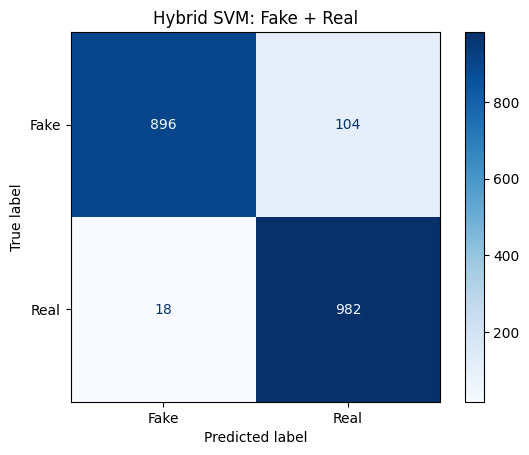

In [64]:
cm = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Hybrid SVM: Fake + Real")
plt.show()

### 3. 예측 결과 파일 작성

In [65]:
with open('./team_test_result.txt', 'w') as f:
    for i in range(len(predictions)):
        f.write(f"{test_file_names[i]} {predictions[i]}\n")

In [66]:
!perl ../eval.pl ./team_test_result.txt ../2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: ./team_test_result.txt
True: ../2501ml_data/label/test_label.txt
Accuracy: 93.90%
Hit: 1878, Total: 2000
